# `EmissionAbsorptionModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `EmissionAbsorptionModel` model. `EmissionAbsorptionModel` models both 21cm emission and absorption observations simultaneously.

In [1]:
# General imports
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

print("pymc version:", pm.__version__)

import bayes_spec

print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi

print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0
caribou_hi version: 1.2.0b0+0.g8f8b122.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionAbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"emission"` and `"absorption"`.

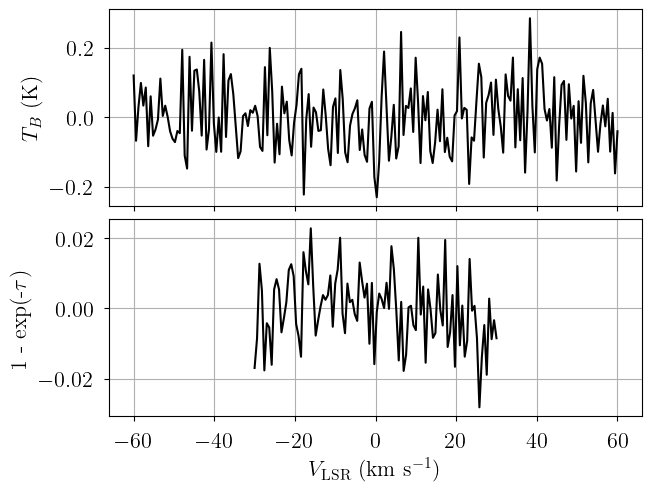

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-60.0, 60.0, 200)  # km s-1
absorption_axis = np.linspace(-30.0, 30.0, 100)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1  # K
rms_absorption = 0.01  # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
axes[1].plot(
    dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-"
)
axes[1].set_xlabel(dummy_data["emission"].xlabel)
axes[0].set_ylabel(dummy_data["emission"].ylabel)
_ = axes[1].set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.01,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([21.0, 19.5, 20.5]),
    "log10_depth": np.array([1.5, 0.5, 2.5]),
    "log10_pressure": np.array([3.5, 3.5, 3.0]),
    "velocity": np.array([5.0, 0.0, -5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.25,
    "larson_power": 0.33,
}

sim_params_emission = sim_params.copy()
sim_params_emission["rms_emission"] = rms_emission
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["rms_absorption"] = rms_absorption
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

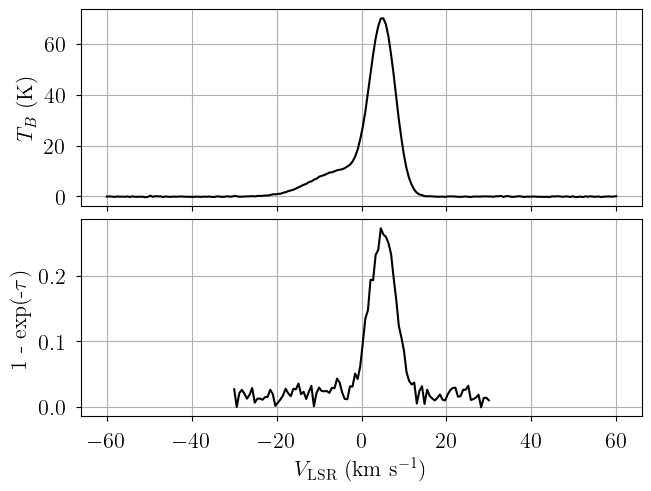

In [5]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = EmissionAbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.01,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

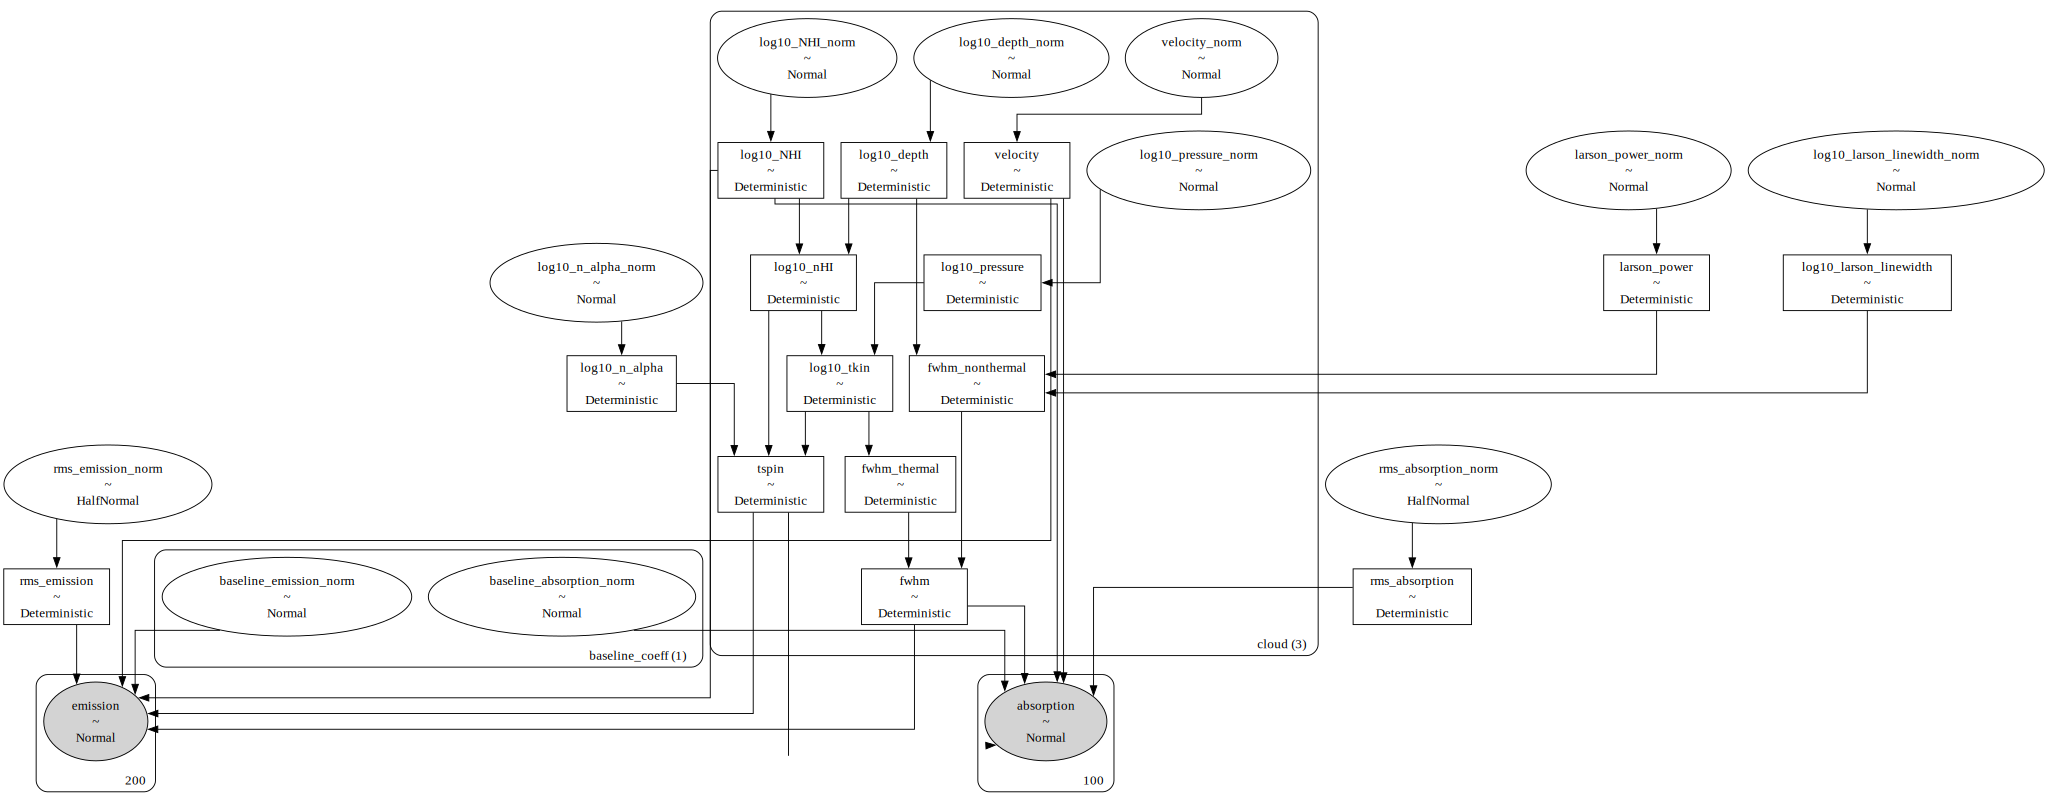

In [7]:
# Plot model graph
model.graph().render("emission_absorption_model", format="png")
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, 1)
   baseline_absorption_norm ~ Normal(0, 1)
             log10_NHI_norm ~ Normal(0, 1)
           log10_depth_norm ~ Normal(0, 1)
        log10_pressure_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
          rms_emission_norm ~ HalfNormal(0, 1)
        rms_absorption_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                log10_depth ~ Deterministic(f(log10_depth_norm))
             log10_pressure ~ Deterministic(f(log10_pressure_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                  log10_nHI ~ Deterministic(f(log10_

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, baseline_emission_norm, emission, larson_power_norm, log10_NHI_norm, log10_depth_norm, log10_larson_linewidth_norm, log10_n_alpha_norm, log10_pressure_norm, rms_absorption_norm, rms_emission_norm, velocity_norm]


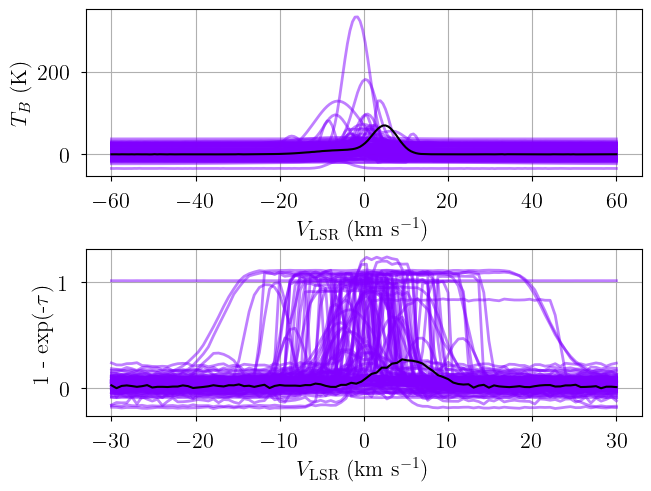

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

Or we can inspect the prior distributions of the derived quantities to check that they are physically reasonable.

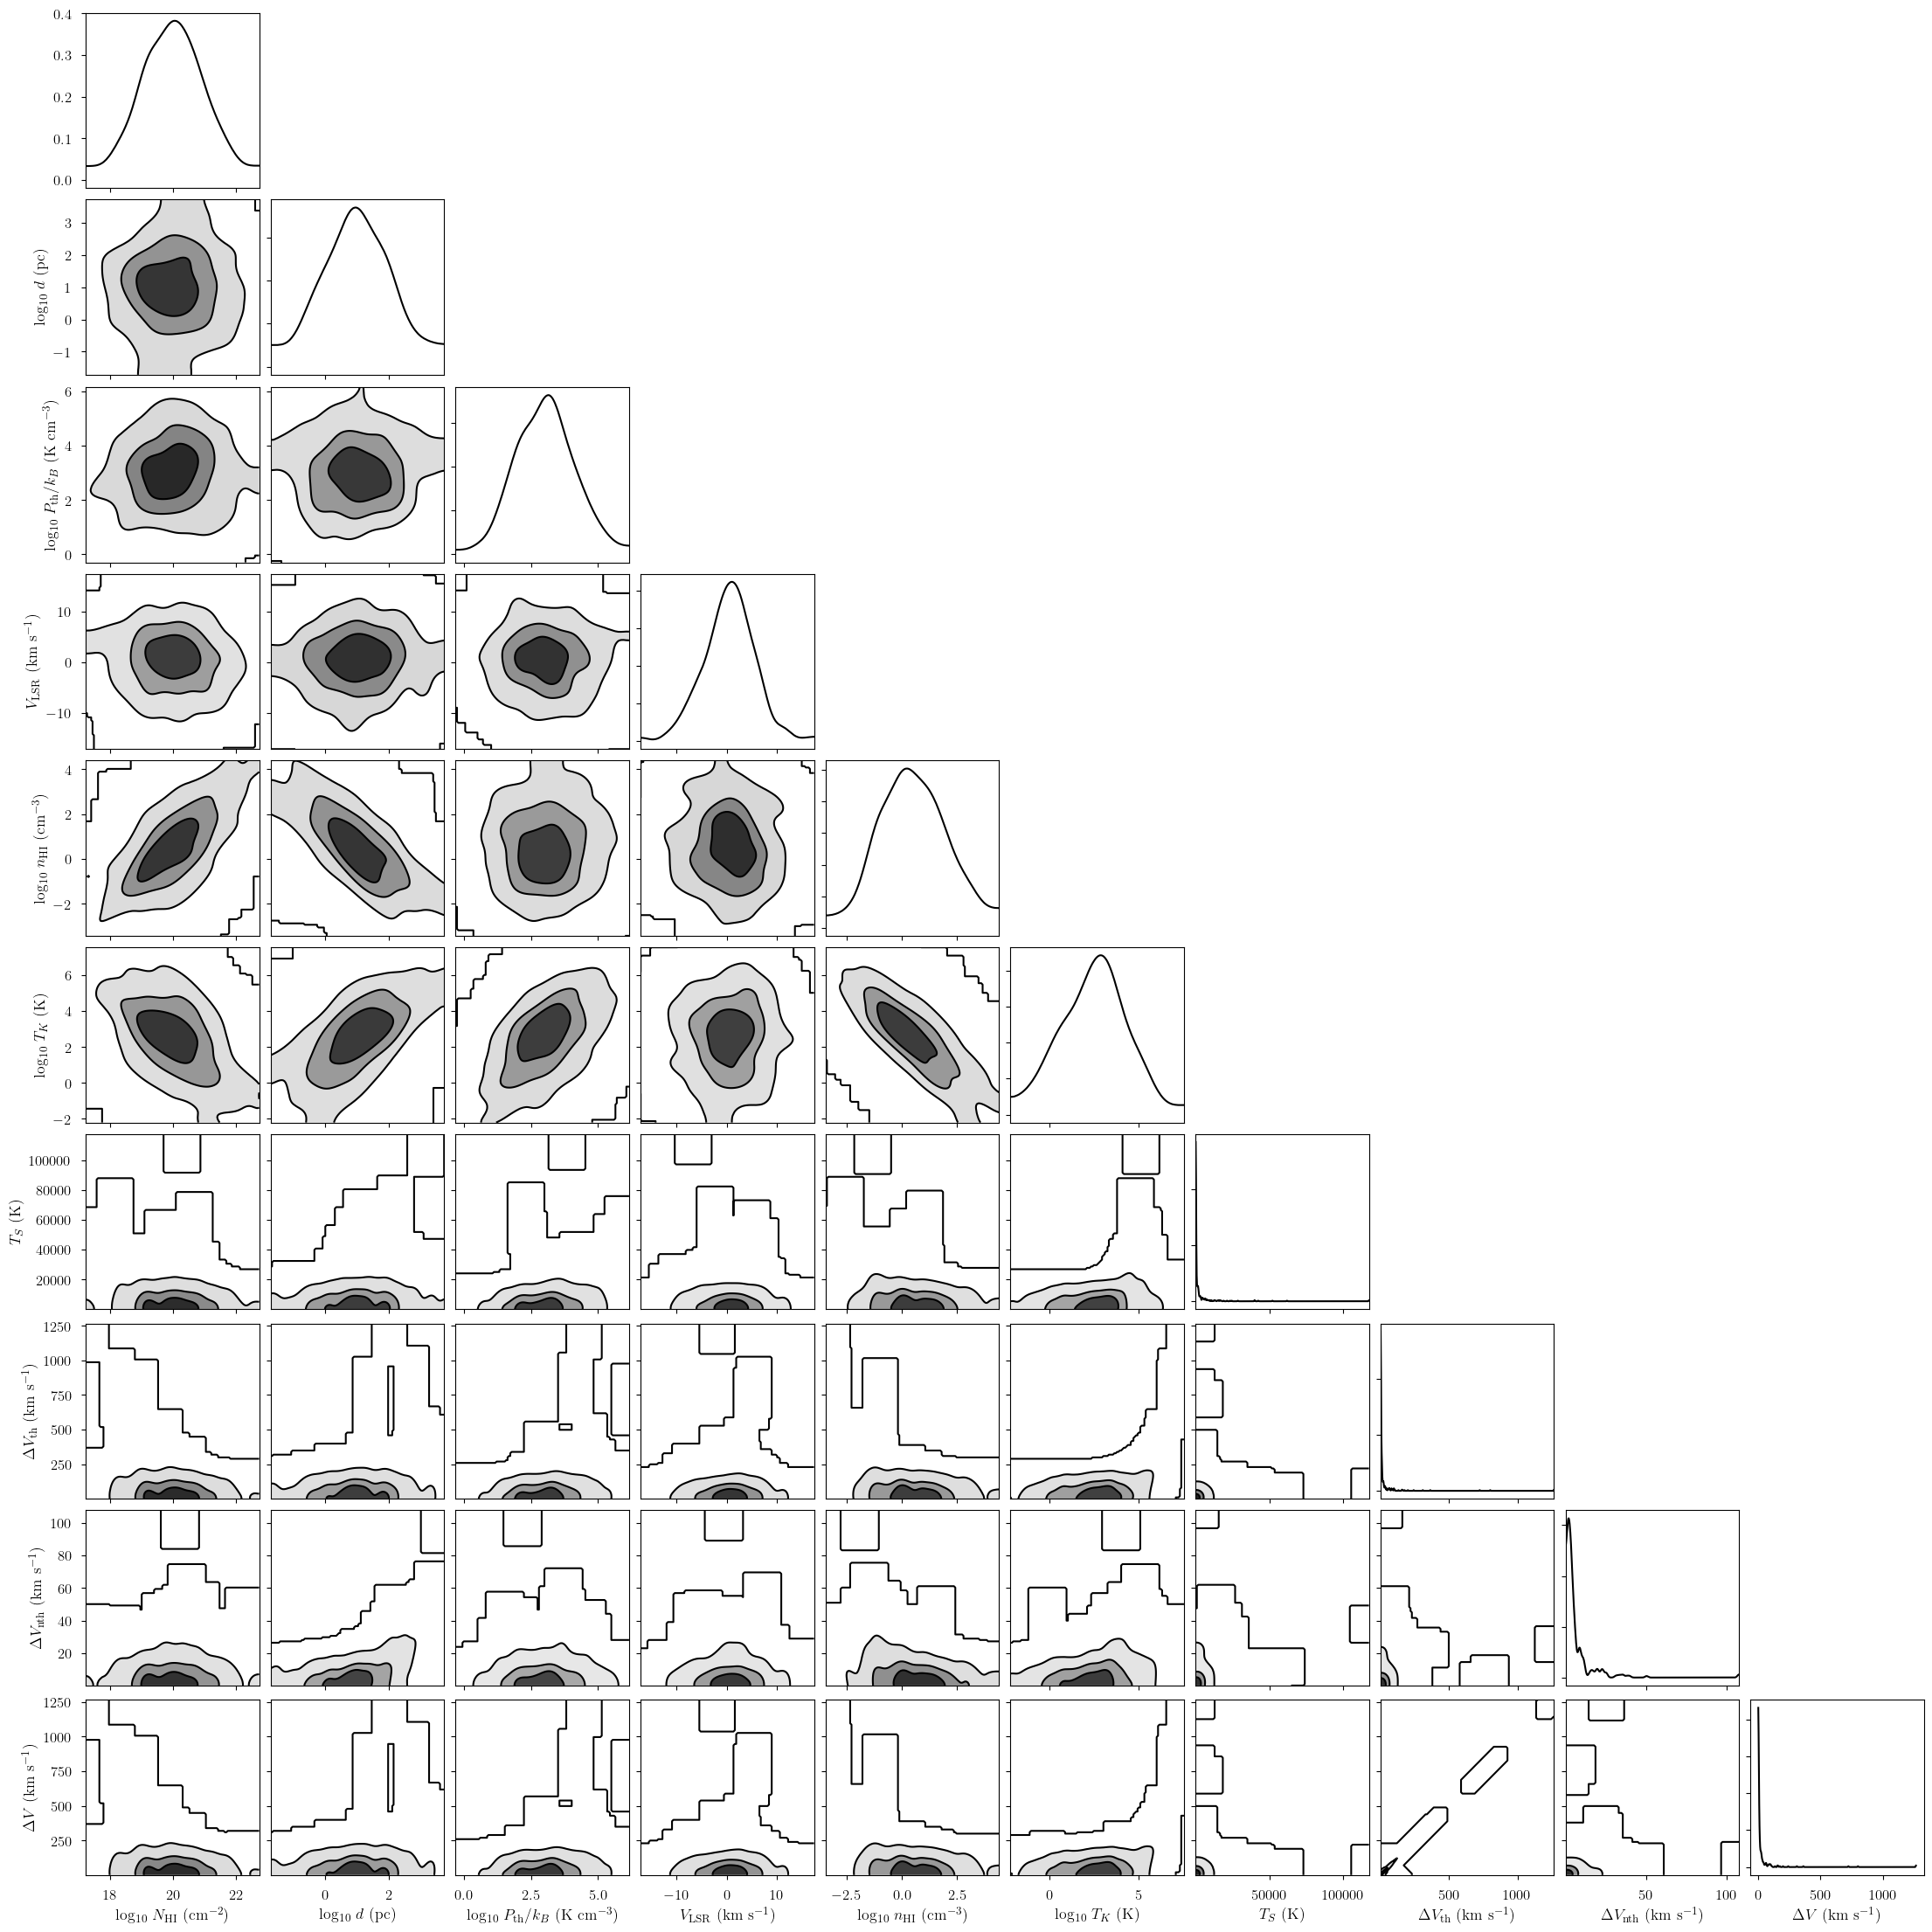

In [10]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior,  # samples
    model.cloud_deterministics,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [11]:
start = time.time()
model.fit(
    n=100_000,  # maximum number of VI iterations
    draws=1_000,  # number of posterior samples
    rel_tolerance=0.01,  # VI relative convergence threshold
    abs_tolerance=0.05,  # VI absolute convergence threshold
    learning_rate=1e-2,  # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 10900
Interrupted at 10,899 [10%]: Average Loss = 99,095


Output()

Runtime: 0.83 minutes


In [12]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean       sd    hdi_3%   hdi_97%  mcse_mean  \
baseline_absorption_norm[0]    -0.478    0.014    -0.505    -0.452      0.000   
baseline_emission_norm[0]      -0.389    0.001    -0.391    -0.388      0.000   
fwhm[0]                         8.519    0.093     8.358     8.701      0.003   
fwhm[1]                        16.366    0.100    16.186    16.563      0.003   
fwhm[2]                         6.452    0.015     6.425     6.481      0.000   
fwhm_nonthermal[0]              7.204    0.058     7.101     7.317      0.002   
fwhm_nonthermal[1]             13.381    0.060    13.262    13.494      0.002   
fwhm_nonthermal[2]              5.465    0.013     5.442     5.492      0.000   
fwhm_thermal[0]                 4.545    0.122     4.322     4.781      0.004   
fwhm_thermal[1]                 9.422    0.133     9.170     9.652      0.004   
fwhm_thermal[2]                 3.430    0.014     3.403     3.455      0.000   
larson_power                    0.419    0.001     0.418     0.420      0.000   
larson_power_norm               0.190    0.005     0.180     0.199      0.000   
log10_NHI[0]                   20.179    0.003    20.173    20.185      0.000   
log10_NHI[1]                   20.498    0.001    20.496    20.500      0.000   
log10_NHI[2]                   20.938    0.000    20.937    20.939      0.000   
log10_NHI_norm[0]               0.179    0.003     0.173     0.185      0.000   
log10_NHI_norm[1]               0.498    0.001     0.496     0.500      0.000   
log10_NHI_norm[2]               0.938    0.000     0.937     0.939      0.000   
log10_depth[0]                  1.457    0.008     1.443     1.473      0.000   
log10_depth[1]                  2.099    0.004     2.092     2.106      0.000   
log10_depth[2]                  1.171    0.001     1.168     1.173      0.000   
log10_depth_norm[0]             0.457    0.008     0.443     0.473      0.000   
log10_depth_norm[1]             1.099    0.004     1.092     1.106      0.000   
log10_depth_norm[2]             0.171    0.001     0.168     0.173      0.000   
log10_larson_linewidth          0.247    0.001     0.246     0.248      0.000   
log10_larson_linewidth_norm     0.471    0.007     0.458     0.482      0.000   
log10_nHI[0]                    0.232    0.009     0.215     0.247      0.000   
log10_nHI[1]                   -0.090    0.004    -0.098    -0.083      0.000   
log10_nHI[2]                    1.278    0.001     1.275     1.281      0.000   
log10_n_alpha                  -6.067    0.852    -7.482    -4.280      0.029   
log10_n_alpha_norm             -0.067    0.852    -1.482     1.720      0.029   
log10_pressure[0]               2.928    0.022     2.889     2.971      0.001   
log10_pressure[1]               3.239    0.011     3.216     3.259      0.000   
log10_pressure[2]               3.730    0.003     3.724     3.736      0.000   
log10_pressure_norm[0]         -0.072    0.022    -0.111    -0.029      0.001   
log10_pressure_norm[1]          0.239    0.011     0.216     0.259      0.000   
log10_pressure_norm[2]          0.730    0.003     0.724     0.736      0.000   
log10_tkin[0]                   2.654    0.023     2.611     2.699      0.001   
log10_tkin[1]                   3.288    0.012     3.266     3.310      0.000   
log10_tkin[2]                   2.410    0.003     2.403     2.416      0.000   
rms_absorption                  0.009    0.001     0.008     0.010      0.000   
rms_absorption_norm             0.897    0.071     0.759     1.029      0.002   
rms_emission                    0.140    0.008     0.126     0.154      0.000   
rms_emission_norm               1.398    0.075     1.256     1.544      0.002   
tspin[0]                      444.648   24.054   401.780   489.346      0.792   
tspin[1]                     1754.707  128.904  1530.070  1959.214      4.441   
tspin[2]                      256.598    2.063   252.526   260.315      0.064   
velocity[0]                     3.508    0.029     3.447     3.5

Sampling: [absorption, emission]


Output()

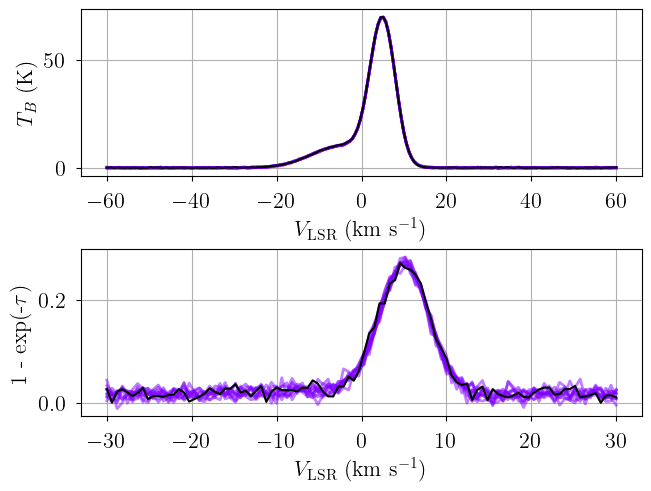

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

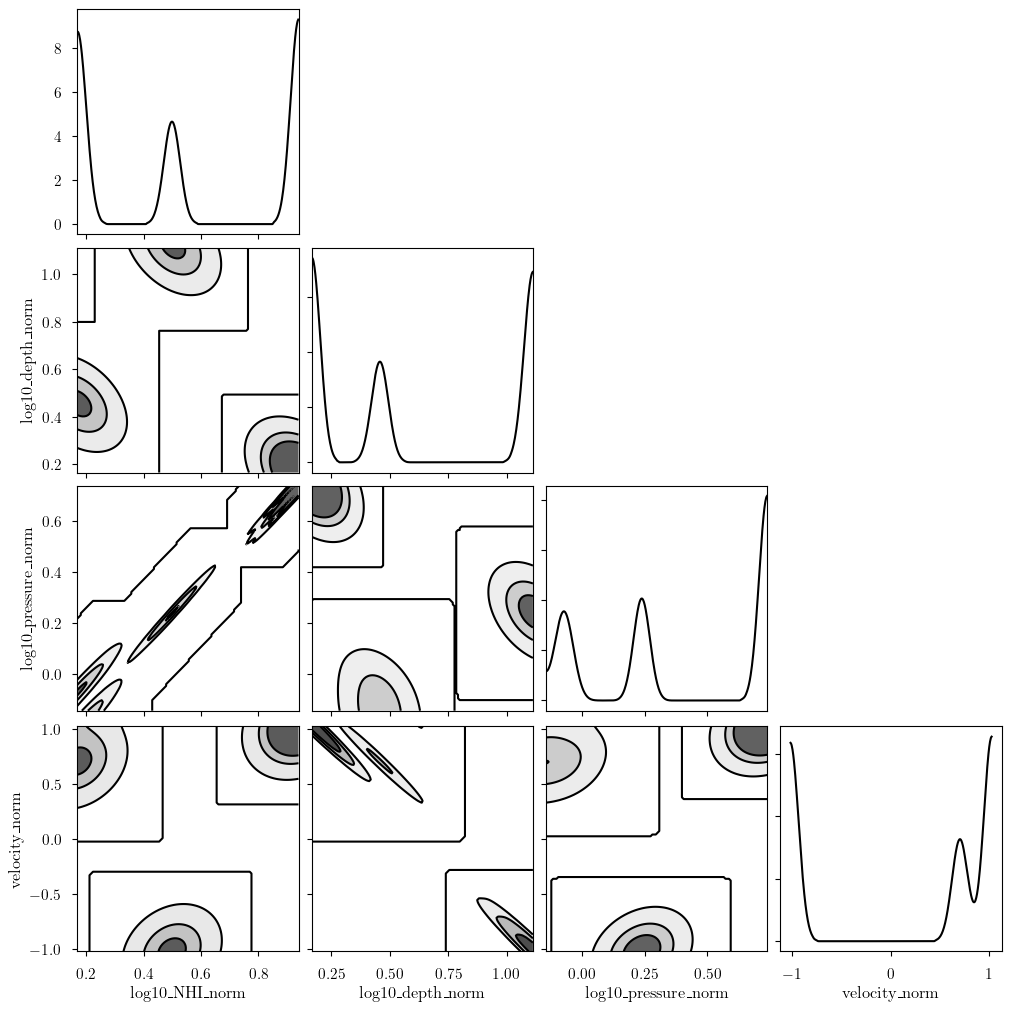

In [14]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.posterior,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [15]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=4,  # number of independent chains
    cores=4,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.05,
        "learning_rate": 1e-2,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10900
Interrupted at 10,899 [10%]: Average Loss = 99,095
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, rms_emission_norm, rms_absorption_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1348 seconds.


Adding log-likelihood to trace


Output()

There were 9 divergences in converged chains.
Runtime: 23.55 minutes


In [16]:
model.solve()

GMM converged to unique solution
3 of 4 chains appear converged.


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [17]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean        sd   hdi_3%   hdi_97%  mcse_mean  \
baseline_absorption_norm[0]    -0.468     0.017   -0.502    -0.439      0.000   
baseline_emission_norm[0]      -0.388     0.001   -0.389    -0.387      0.000   
fwhm[0]                         8.022     1.214    5.728     9.919      0.069   
fwhm[1]                        16.296     0.266   15.784    16.757      0.010   
fwhm[2]                         6.550     0.043    6.475     6.626      0.003   
fwhm_nonthermal[0]              4.941     2.026    1.306     8.246      0.088   
fwhm_nonthermal[1]             11.300     3.251    4.821    15.370      0.152   
fwhm_nonthermal[2]              5.547     0.032    5.486     5.606      0.001   
fwhm_thermal[0]                 5.948     1.391    3.643     8.509      0.053   
fwhm_thermal[1]                10.928     2.817    6.833    15.964      0.119   
fwhm_thermal[2]                 3.484     0.052    3.381     3.566      0.003   
larson_power                    0.393     0.075    0.262     0.545      0.003   
larson_power_norm              -0.073     0.754   -1.375     1.447      0.028   
log10_NHI[0]                   19.798     0.254   19.342    20.158      0.016   
log10_NHI[1]                   20.493     0.017   20.460    20.521      0.001   
log10_NHI[2]                   20.977     0.018   20.948    21.002      0.001   
log10_NHI_norm[0]              -0.202     0.254   -0.658     0.158      0.016   
log10_NHI_norm[1]               0.493     0.017    0.460     0.521      0.001   
log10_NHI_norm[2]               0.977     0.018    0.948     1.002      0.001   
log10_depth[0]                  1.109     0.568   -0.002     2.101      0.023   
log10_depth[1]                  2.092     0.503    1.157     3.075      0.024   
log10_depth[2]                  1.368     0.307    0.815     1.959      0.013   
log10_depth_norm[0]             0.109     0.568   -1.002     1.101      0.023   
log10_depth_norm[1]             1.092     0.503    0.157     2.075      0.024   
log10_depth_norm[2]             0.368     0.307   -0.185     0.959      0.013   
log10_larson_linewidth          0.221     0.095    0.022     0.388      0.003   
log10_larson_linewidth_norm     0.210     0.951   -1.779     1.878      0.028   
log10_nHI[0]                    0.200     0.497   -0.699     1.154      0.017   
log10_nHI[1]                   -0.088     0.500   -1.066     0.851      0.024   
log10_nHI[2]                    1.119     0.306    0.561     1.708      0.013   
log10_n_alpha                  -6.102     0.987   -8.010    -4.312      0.022   
log10_n_alpha_norm             -0.102     0.987   -2.010     1.688      0.022   
log10_pressure[0]               3.105     0.636    2.007     4.327      0.021   
log10_pressure[1]               3.341     0.638    2.207     4.637      0.030   
log10_pressure[2]               3.584     0.306    3.011     4.154      0.013   
log10_pressure_norm[0]          0.105     0.636   -0.993     1.327      0.021   
log10_pressure_norm[1]          0.341     0.638   -0.793     1.637      0.030   
log10_pressure_norm[2]          0.584     0.306    0.011     1.154      0.013   
log10_tkin[0]                   2.864     0.206    2.505     3.229      0.007   
log10_tkin[1]                   3.387     0.228    3.034     3.762      0.009   
log10_tkin[2]                   2.424     0.013    2.398     2.444      0.001   
rms_absorption                  0.009     0.001    0.008     0.010      0.000   
rms_absorption_norm             0.904     0.067    0.790     1.042      0.002   
rms_emission                    0.102     0.005    0.093     0.112      0.000   
rms_emission_norm               1.023     0.051    0.929     1.121      0.001   
tspin[0]                      790.036   368.086  251.263  1490.827     14.604   
tspin[1]                     2396.381  1258.651  758.990  4938.279     57.721   
tspin[2]                      264.521     7.897  249.033   277.009      0.410   
velocity[0]                     1.503     1.306   -0.773     3.3

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption, emission]


Output()

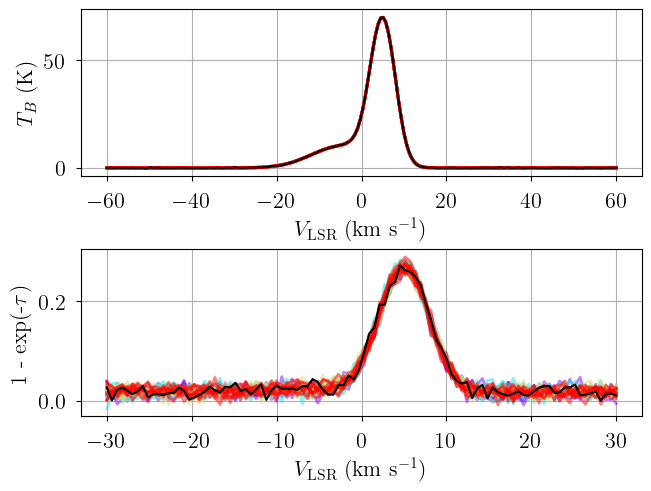

In [18]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

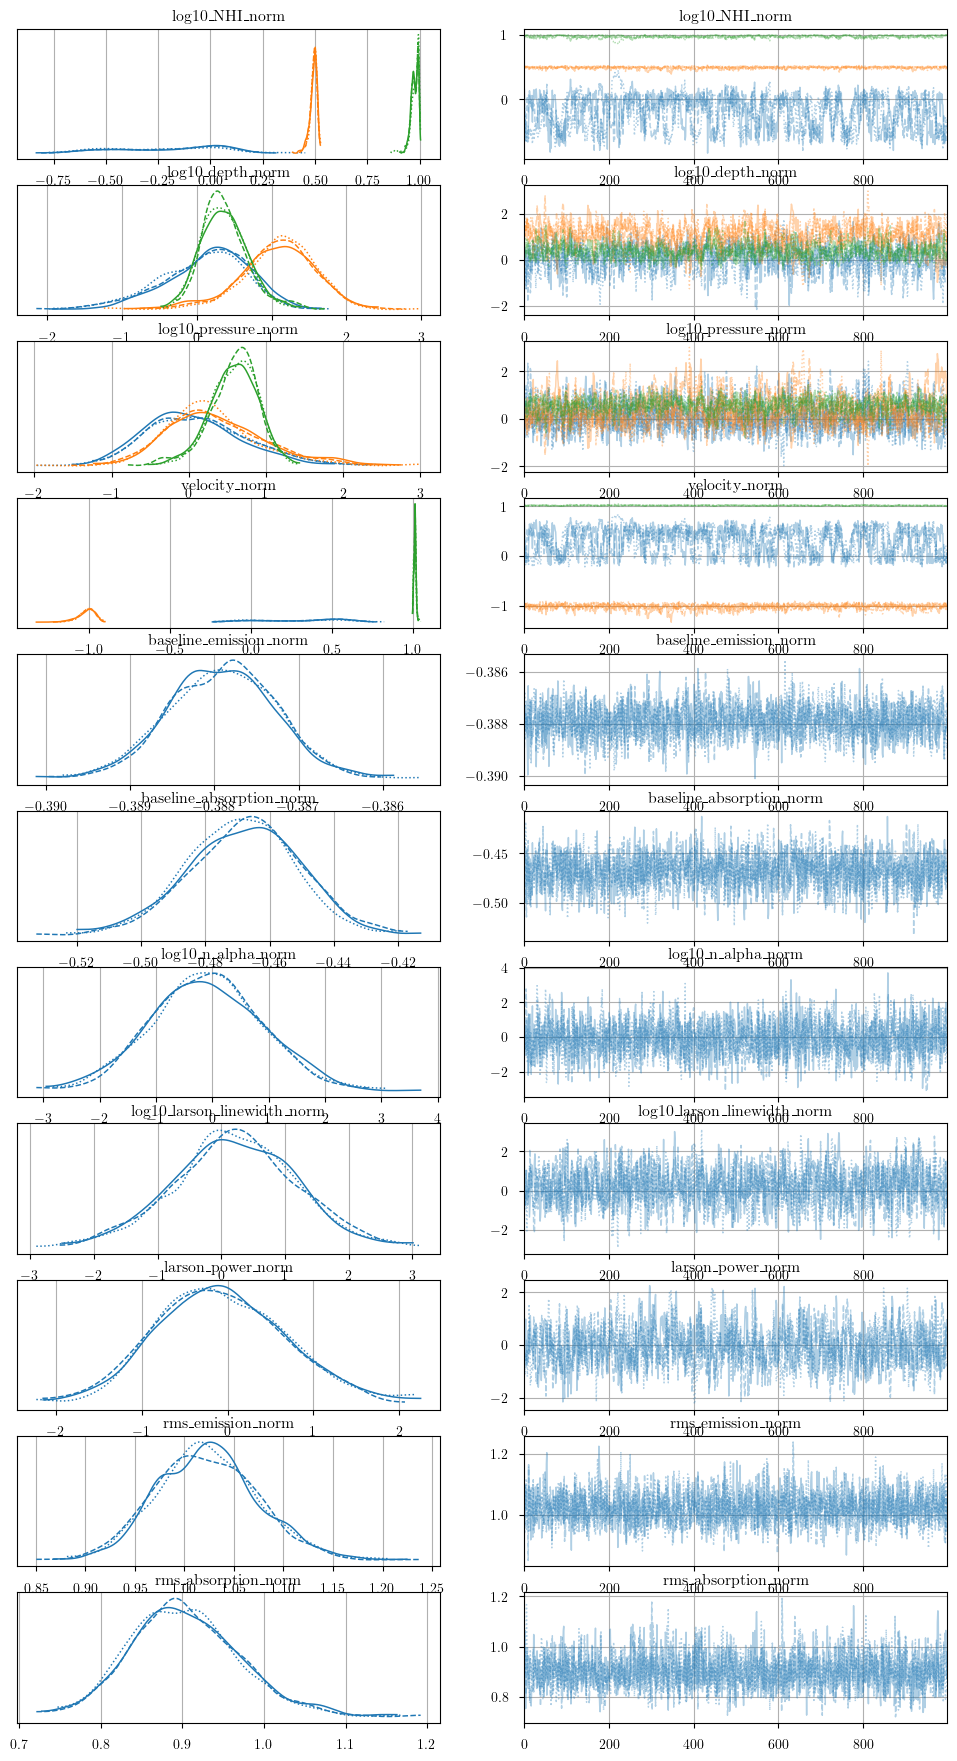

In [19]:
from bayes_spec.plots import plot_traces

_ = plot_traces(
    model.trace.solution_0,
    model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs,
)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

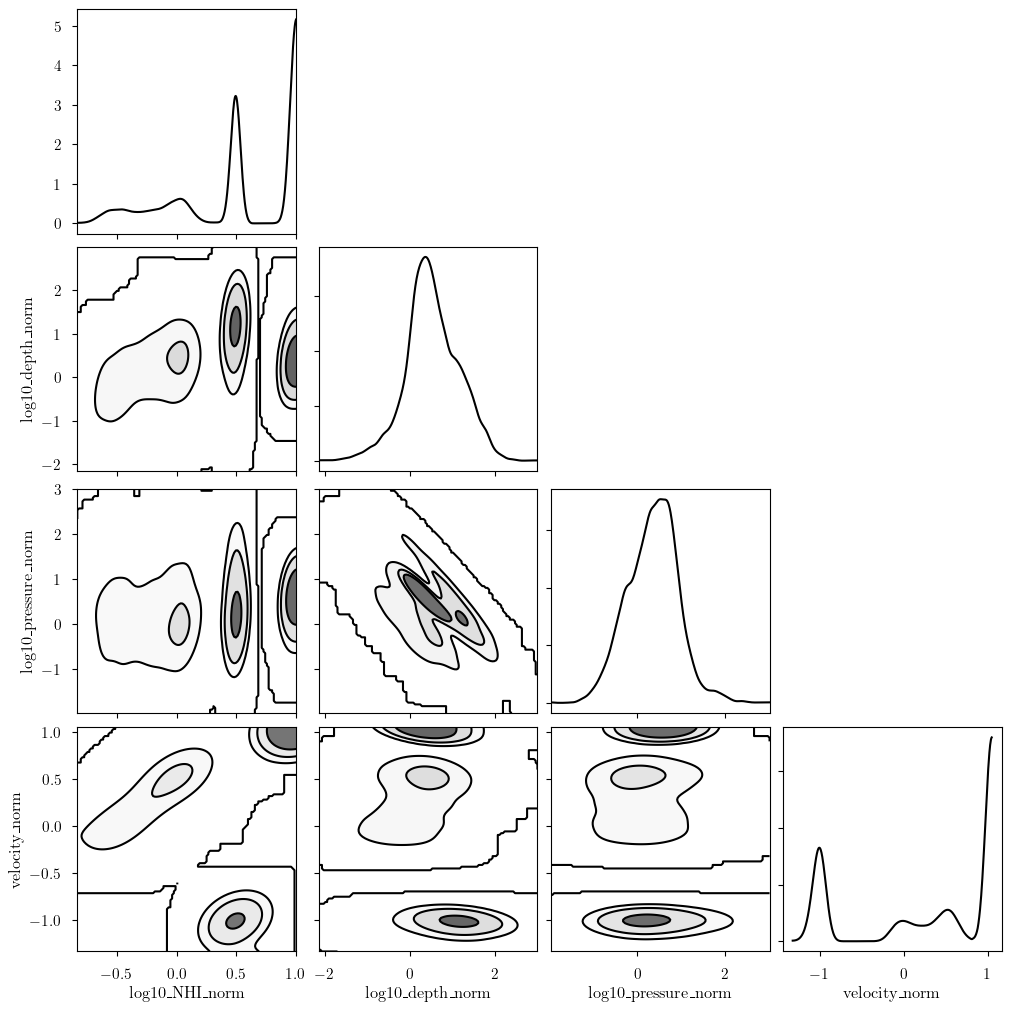

In [20]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

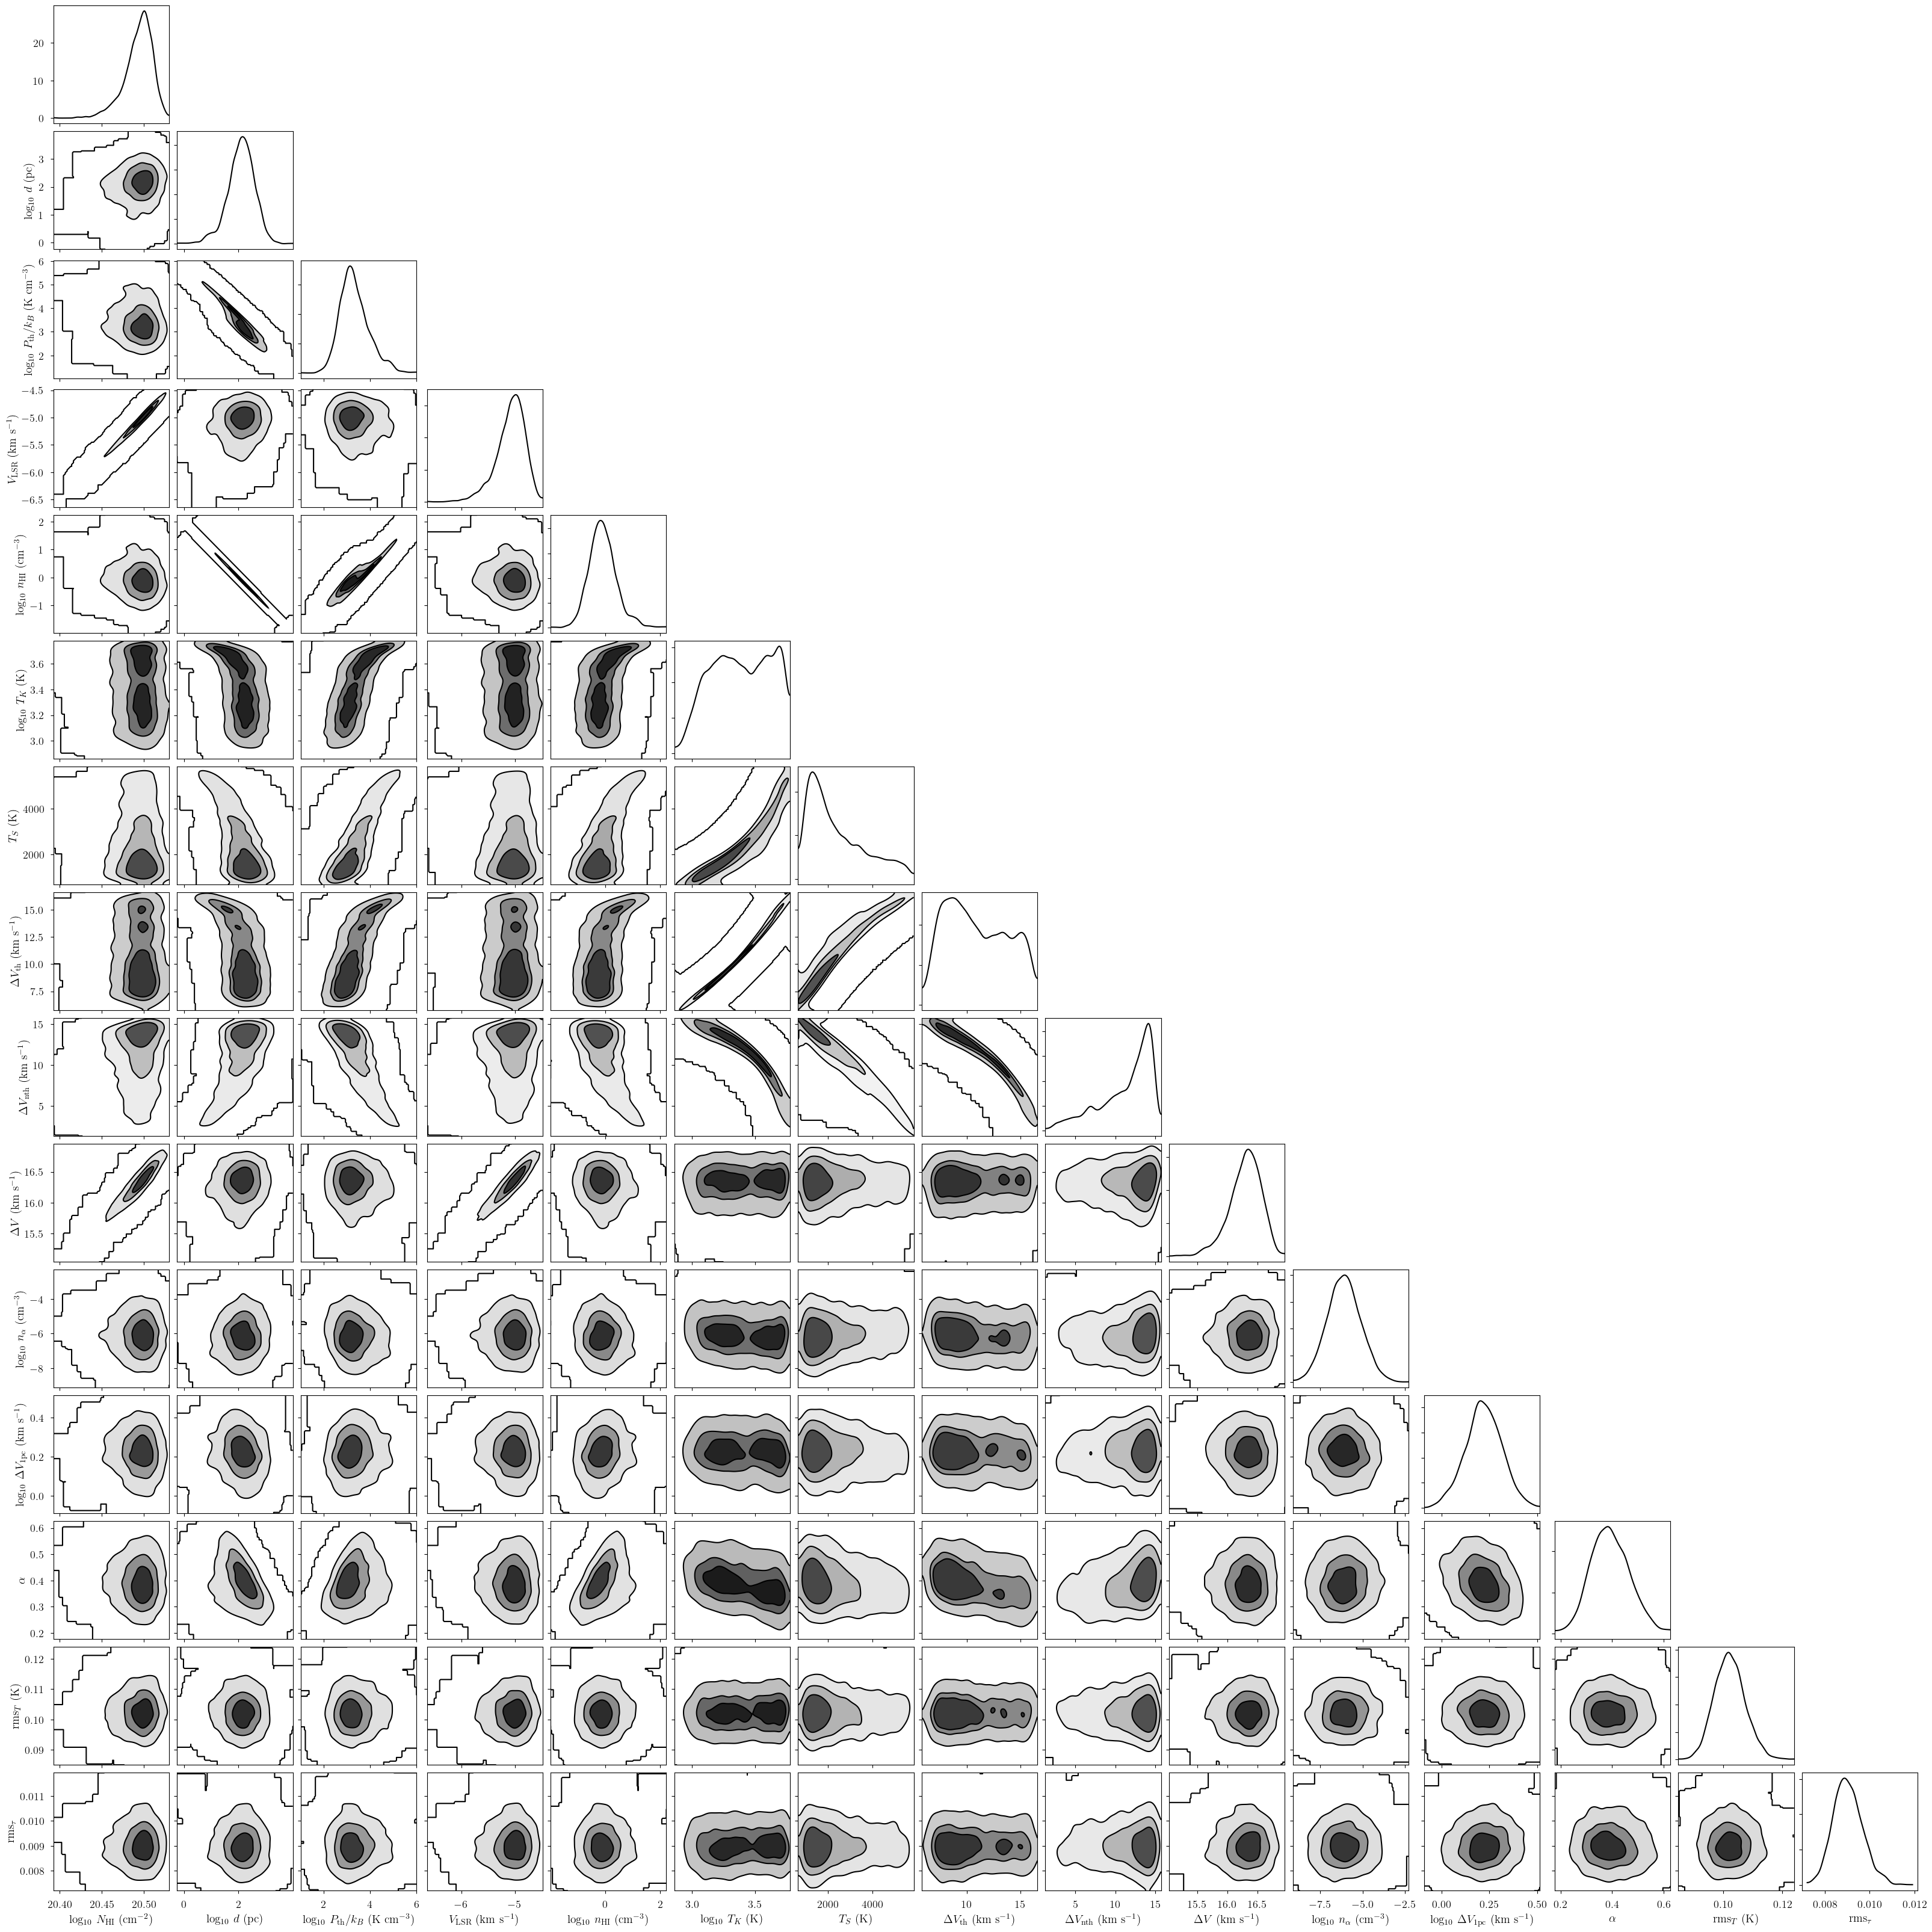

In [21]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1),  # samples
    model.cloud_deterministics + model.hyper_deterministics,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
point_stats = az.summary(model.trace.solution_0, kind="stats", hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -894.498797493108


mean        sd  hdi_16%   hdi_84%
baseline_absorption_norm[0]    -0.468     0.017   -0.485    -0.451
baseline_emission_norm[0]      -0.388     0.001   -0.389    -0.387
fwhm[0]                         8.022     1.214    6.968     9.570
fwhm[1]                        16.296     0.266   16.084    16.575
fwhm[2]                         6.550     0.043    6.515     6.598
fwhm_nonthermal[0]              4.941     2.026    2.668     7.118
fwhm_nonthermal[1]             11.300     3.251    9.985    14.958
fwhm_nonthermal[2]              5.547     0.032    5.524     5.582
fwhm_thermal[0]                 5.948     1.391    4.111     6.999
fwhm_thermal[1]                10.928     2.817    6.997    13.178
fwhm_thermal[2]                 3.484     0.052    3.452     3.549
larson_power                    0.393     0.075    0.311     0.459
larson_power_norm              -0.073     0.754   -0.888     0.589
log10_NHI[0]                   19.798     0.254   19.582    20.122
log10_NHI[1]                   20.493     0.017   20.484    20.513
log10_NHI[2]                   20.977     0.018   20.969    21.000
log10_NHI_norm[0]              -0.202     0.254   -0.418     0.122
log10_NHI_norm[1]               0.493     0.017    0.484     0.513
log10_NHI_norm[2]               0.977     0.018    0.969     1.000
log10_depth[0]                  1.109     0.568    0.695     1.780
log10_depth[1]                  2.092     0.503    1.674     2.577
log10_depth[2]                  1.368     0.307    1.011     1.591
log10_depth_norm[0]             0.109     0.568   -0.305     0.780
log10_depth_norm[1]             1.092     0.503    0.674     1.577
log10_depth_norm[2]             0.368     0.307    0.011     0.591
log10_larson_linewidth          0.221     0.095    0.143     0.330
log10_larson_linewidth_norm     0.210     0.951   -0.573     1.301
log10_nHI[0]                    0.200     0.497   -0.377     0.545
log10_nHI[1]                   -0.088     0.500   -0.587     0.311
log10_nHI[2]                    1.119     0.306    0.891     1.470
log10_n_alpha                  -6.102     0.987   -7.103    -5.138
log10_n_alpha_norm             -0.102     0.987   -1.103     0.862
log10_pressure[0]               3.105     0.636    2.391     3.621
log10_pressure[1]               3.341     0.638    2.623     3.761
log10_pressure[2]               3.584     0.306    3.319     3.901
log10_pressure_norm[0]          0.105     0.636   -0.609     0.621
log10_pressure_norm[1]          0.341     0.638   -0.377     0.761
log10_pressure_norm[2]          0.584     0.306    0.319     0.901
log10_tkin[0]                   2.864     0.206    2.655     3.095
log10_tkin[1]                   3.387     0.228    3.241     3.748
log10_tkin[2]                   2.424     0.013    2.416     2.440
rms_absorption                  0.009     0.001    0.008     0.010
rms_absorption_norm             0.904     0.067    0.833     0.961
rms_emission                    0.102     0.005    0.097     0.107
rms_emission_norm               1.023     0.051    0.968     1.067
tspin[0]                      790.036   368.086  299.315   944.120
tspin[1]                     2396.381  1258.651  826.819  2814.115
tspin[2]                      264.521     7.897  259.469   274.078
velocity[0]                     1.503     1.306    0.348     3.222
velocity[1]                    -5.085     0.268   -5.252    -4.779
velocity[2]                     5.061     0.034    5.031     5.098
velocity_norm[0]                0.301     0.261    0.070     0.644
velocity_norm[1]               -1.017     0.054   -1.050    -0.956
velocity_norm[2]                1.012     0.007    1.006     1.020